### A sequential workflow that calculates BMI using the provided weight and height, assigns a BMI category label, and offers relevant health tips.

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI()

In [17]:
class BMIState(TypedDict):
    height_in_meter: float
    weight_in_kg: float
    bmi: float
    bmi_label: str
    tips: str

In [18]:
def calculate_bmi(state: BMIState) -> BMIState:
    height = state["height_in_meter"]
    weight = state["weight_in_kg"]
    bmi = weight / (height ** 2)
    state["bmi"] = round(bmi, 2)

    return state

In [19]:
def get_bmi_label(state: BMIState) -> BMIState:
    bmi = state["bmi"]

    if bmi < 18.5:
        state["bmi_label"] = "Underweight"
    elif 18.5 <= bmi < 25:
        state["bmi_label"] = "Normal"
    elif 25 <= bmi < 30:
        state["bmi_label"] = "Overweight"
    else:
        state["bmi_label"] = "Obese"

    return state

In [29]:
def get_tips(state: BMIState) -> BMIState:

    bmi_label = state["bmi_label"]

    if bmi_label == "Normal":
        state["tips"] = "Continue as usual"
        return state

    prompt = f"Generate 2 tips for according to the bmi label - {bmi_label}"

    response = model.invoke(prompt).content
    state["tips"] = response

    return state

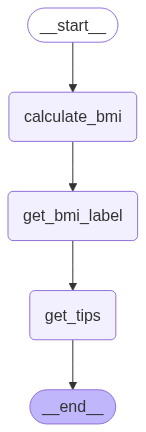

In [30]:
graph = StateGraph(BMIState)

graph.add_node("calculate_bmi", calculate_bmi)
graph.add_node("get_bmi_label", get_bmi_label)
graph.add_node("get_tips", get_tips)

graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", "get_bmi_label")
graph.add_edge("get_bmi_label", "get_tips")
graph.add_edge("get_tips", END)

workflow = graph.compile()
workflow

In [37]:
initial_state = {"height_in_meter": 1.78, "weight_in_kg": 80}
final_state = workflow.invoke(initial_state)

In [38]:
print(final_state)

{'height_in_meter': 1.78, 'weight_in_kg': 80, 'bmi': 25.25, 'bmi_label': 'Overweight', 'tips': "1. Consult with a healthcare professional: If your BMI label indicates that you are overweight, it's important to speak with a doctor or registered dietitian to develop a personalized plan for achieving a healthy weight. They can provide guidance on nutrition, exercise, and lifestyle changes that can help you reach a more optimal BMI.\n\n2. Focus on making gradual, sustainable changes: Rather than trying to implement drastic changes all at once, focus on making small, sustainable adjustments to your diet and exercise routine. This can help you develop healthy habits over time that will support long-term weight management and overall health. Remember that slow and steady progress is more effective and sustainable than quick fixes."}
